#EECS 504 Computer Vision Final Project Optical Flow


Authors:
Yen-Ning Tai, tyenning

Hsuan-Cheng Chen, hsuancc

Po-Kang Chen, pkchen

#Mount Drive


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


# Starting



In [3]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
import os
import copy
from PIL import Image
from torchsummary import summary
import torch
import torchvision
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, models, transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import csv
import random
import tqdm
from tqdm import tqdm_notebook
print("PyTorch Version: ",torch.__version__)
print("Torchvision Version: ",torchvision.__version__)
# Detect if we have a GPU available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
if torch.cuda.is_available():
    print("Using the GPU!")
else:
    print("WARNING: Could not find GPU! Using CPU only. If you want to enable GPU, please to go Edit > Notebook Settings > Hardware Accelerator and select GPU.")


PyTorch Version:  1.4.0
Torchvision Version:  0.5.0
Using the GPU!


In [0]:
# custom datasets
class KittiDataset(Dataset):
    def __init__(self, anc_path, pos_path, neg_path, transform = None):
        self.anc_path = anc_path
        self.pos_path = pos_path
        self.neg_path = neg_path
        self.transform = transform

    def __getitem__(self, idx):
        a_path = os.path.join(self.anc_path, str(idx+1) + ".png")
        a = Image.open(a_path).convert('RGB') 
        if self.transform:
            a = self.transform(a)
        array = np.asarray(a)
        a = torch.from_numpy(array)
        a = a.permute(2,0,1)
        
        p_path = os.path.join(self.pos_path, str(idx+1) + ".png")
        p = Image.open(p_path).convert('RGB') 
        if self.transform:
            p = self.transform(p)
        array = np.asarray(p)
        p = torch.from_numpy(array)
        p = p.permute(2,0,1)
        
        n_path = os.path.join(self.neg_path, str(idx+1) + ".png")
        n = Image.open(n_path).convert('RGB') 
        if self.transform:
            n = self.transform(n)
        array = np.asarray(n)
        n = torch.from_numpy(array)
        n = n.permute(2,0,1)
        return a, p, n

    def __len__(self):
        return 10000

#Loader

In [0]:
# dataloader
def get_dataloaders(batch_size):
    tranform = None
    n_worker = 2
    anc_path = "/content/drive/My Drive/dataset/patches_30k/anc"
    pos_path = "/content/drive/My Drive/dataset/patches_30k/pos"
    neg_path = "/content/drive/My Drive/dataset/patches_30k/neg"
    data_train = KittiDataset(anc_path, pos_path, neg_path, transform = None)
    data_loader = DataLoader(data_train, batch_size, shuffle=False, num_workers=n_worker)
    return data_loader

#Net (Feature Embedding)

In [0]:
#https://github.com/intel-isl/dcflow/blob/master/net/deploy.prototxt
import torch
import torch.nn as nn
'''
  Input: 9 * 9 * 3
  Output: 9 * 9 * 64 
'''
def conv(in_channels, out_channels):
    kernel_size_conv = 3
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel_size_conv, padding = 1),
        nn.ReLU(inplace=True),
    )

class dcflow(nn.Module):

    def __init__(self):
        super().__init__()
        init_modules = self.modules()
        in_channel = 3 
        kernel_size_conv = 3
        d_out = 64

        #Down
        self.dconv_down1 = conv(in_channel , d_out)
        self.dconv_down2 = conv(d_out    , d_out)
        self.dconv_down3 = conv(d_out    , d_out)
        self.conv_last = nn.Conv2d(d_out, d_out , kernel_size_conv, padding = 1)

    def forward(self, x):
        #Convdown + Maxpool each layer
        conv1 = self.dconv_down1(x)
        conv2 = self.dconv_down2(conv1)
        conv3 = self.dconv_down3(conv2)
        out = self.conv_last(conv3)
        #Normalized
        out = out / (torch.norm(out, dim = 1, keepdim=True) + 1e-15)
        return out

In [7]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = dcflow() 
model = model.to(device)
# check keras-like model summary using torchsummary
summary(model, input_size=(3, 9, 9))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1             [-1, 64, 9, 9]           1,792
              ReLU-2             [-1, 64, 9, 9]               0
            Conv2d-3             [-1, 64, 9, 9]          36,928
              ReLU-4             [-1, 64, 9, 9]               0
            Conv2d-5             [-1, 64, 9, 9]          36,928
              ReLU-6             [-1, 64, 9, 9]               0
            Conv2d-7             [-1, 64, 9, 9]          36,928
Total params: 112,576
Trainable params: 112,576
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.28
Params size (MB): 0.43
Estimated Total Size (MB): 0.71
----------------------------------------------------------------


#LOSS

In [0]:
class TripletLoss(nn.Module):
    """
    Triplet loss
    Takes embeddings of an anchor sample, a positive sample and a negative sample
    Args:
      anchor: 9 * 9 * 64
      positive: 9 * 9 * 64
      negative: 9 * 9 * 64
    """

    def __init__(self, margin):
        super(TripletLoss, self).__init__()
        self.margin = margin

    def forward(self, anchor, positive, negative, size_average=True):
        #Switch to 1 * 1 * 64
        anchor_out = anchor[4,4,:]
        positive_out = positive[4,4,:]
        negative_out = negative[4,4,:]
        distance_positive = (anchor_out - positive_out).pow(2).sum(1)  # .pow(.5)
        distance_negative = (anchor_out - negative_out).pow(2).sum(1)  # .pow(.5)
        losses = F.relu(distance_positive - distance_negative + self.margin)
        return losses.mean() if size_average else losses.sum()


#Train 

In [0]:
def train_model(model, dataloaders, criterion, optimizer, save_dir, num_epochs = 10):
    '''
    Args:
        model: The NN to train (Dcflow)
        dataloaders: loaders a, p, n
        criterion: The Loss function
        optimizer: Pytroch optimizer. The algorithm to update weights 
        num_epochs: How many epochs to train for
        save_dir: Where to save the best model weights that are found. Using None will not write anything to disk.

    Returns:
        model: The trained NN
        tr_loss_history: list, training Loss history. Recording freq: one epoch.
    '''

    dset_num = np.arange(len(dataloaders))

    val_loss_history = []
    tr_loss_history = []
    
    best_model_wts = copy.deepcopy(model.state_dict())
    best_val_loss = 1000.0

    ##### Loop through number of epochs ######
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch + 1, num_epochs))
        print('-' * 10)
        # Each epoch has a training and validation phase
        model.train()  # Set model to training mode

        # loss and number of correct prediction for the current batch
        running_loss = 0.0

        # Iterate over data (anchor, positive, negative)
        # TQDM has nice progress bars
        for a, p, n in tqdm.notebook.tqdm(dataloaders):
            # Input to device 
            a = a.to(device)
            a = a.float()
            p = p.to(device)
            p = p.float()
            n = n.to(device)
            n = n.float()

            ## Forward Pass: compute the outputs, calculate the loss, update the model parameters
            # <output> Each of the anchor, positive, negative should input to model to gain the output
            output_a = model(a)
            output_p = model(p)
            output_n = model(n)
            # <Loss>
            loss = criterion(output_a, output_p, output_n)
            
            ## Backward pass
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        epoch_loss = running_loss / len(dataloaders.dataset)
        print('Loss: {:.4f}'.format(epoch_loss))

        tr_loss_history.append(epoch_loss)

    return model, tr_loss_history

# Tune Here !!!!!

In [18]:
### change epochs ###
num_epochs = 10

### IO
# Directory to save weights to
save_dir = "/content/drive/My Drive/Weight"

### Dataset
dataloaders = get_dataloaders(batch_size=16)

### Create dcflow model
model = dcflow()
model = model.to(device)

### TripletLoss Criterion
criterion = TripletLoss(1)
criterion = criterion.to(device)


### Add all params for optimization
param_list = [{'params': model.parameters()}]

### Create optimizer ## change learning rate here!!!!!!!!!
optimizer = optim.Adam(params=param_list, lr=1e-4, weight_decay=0.0005)
# optimizer = optim.SGD(model.parameters(), lr=1e-2, momentum=0.9)

### Train the model!
model_trained, tr_his = train_model(model=model, dataloaders = dataloaders, criterion=criterion, optimizer=optimizer,
           save_dir=save_dir, num_epochs=num_epochs)

### Save the Model
PATH = "/content/drive/My Drive/Weight/dcflow_state_dict_ep10_10000_normed_new.pth"


torch.save(model_trained.state_dict(), PATH)

Epoch 1/10
----------



Loss: 0.0381
Epoch 2/10
----------



Loss: 0.0296
Epoch 3/10
----------



Loss: 0.0271
Epoch 4/10
----------



Loss: 0.0248
Epoch 5/10
----------



Loss: 0.0220
Epoch 6/10
----------



Loss: 0.0212
Epoch 7/10
----------



Loss: 0.0199
Epoch 8/10
----------



Loss: 0.0178
Epoch 9/10
----------



Loss: 0.0170
Epoch 10/10
----------



Loss: 0.0160


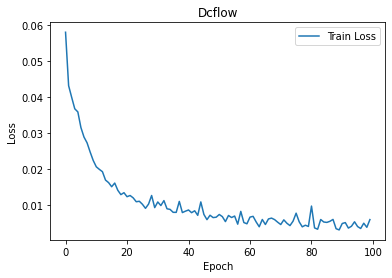

In [0]:

x = np.arange(num_epochs)
plt.figure()
plt.plot(x, tr_his)
# plt.plot(x, val_his)
plt.legend(['Train Loss', 'Val Loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Dcflow')
plt.show()